# Dylan

### Notes
**Ideas:**  
Split data into blocks, maybe store the data 3 dimensionally.  

**Dimensions:**  
- Location
- Block (10 sequential days)
- Day
- Weather data
  
**Test Train Split Legend:**  
Source  
[[4, 5, 1, 9],  
 [2, 9, 5, 6],  
 [9, 5, 1, 8],  
 [8, 1, 2, 7]]  
Features (X) → Target (Y)  
[[4, 5, 1]   → [[9]  
 [2, 9, 5]   →  [6]  
 [9, 5, 1]   →  [8]  
 [8, 1, 2]   →  [7]]  

### Imports

In [1]:
import pandas as pd
#import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as sk
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
raw_data = pd.read_csv('./weatherAUS.csv')
# Remove columns that either has a large amount of missing data or are not suitable for machine learning
raw_data.drop(columns=['Sunshine', 'Evaporation', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], inplace=True)
raw_data

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,01-12-2008,Albury,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8
1,02-12-2008,Albury,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3
2,03-12-2008,Albury,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2
3,04-12-2008,Albury,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5
4,05-12-2008,Albury,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4
145456,22-06-2017,Uluru,3.6,25.3,0.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5
145457,23-06-2017,Uluru,5.4,26.9,0.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1
145458,24-06-2017,Uluru,7.8,27.0,0.0,28.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0


### Date conversion

In [3]:
def to_iso_date(_date: str) -> str:
	'''Converts the date from dd-mm-yyyy to yyyy-mm-dd'''
	return datetime.strptime(_date, '%d-%m-%Y').strftime("%Y-%m-%d")

def extract_year(_date: str) -> int:
	'''Returns the year component of the date'''
	return datetime.strptime(_date, '%Y-%m-%d').year

def extract_month(_date: str) -> int:
	'''Returns the month component of the date'''
	return datetime.strptime(_date, '%Y-%m-%d').month

def extract_day(_date: str) -> int:
	'''Returns the day component of the date'''
	return datetime.strptime(_date, '%Y-%m-%d').day

redated = raw_data.copy()
redated['Date'] = redated['Date'].apply(to_iso_date)
redated['Year'] = redated['Date'].apply(extract_year)
redated['Month'] = redated['Date'].apply(extract_month)
redated['Day'] = redated['Date'].apply(extract_day)
redated

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
0,2008-12-01,Albury,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,2008,12,1
1,2008-12-02,Albury,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,2008,12,2
2,2008-12-03,Albury,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,2008,12,3
3,2008-12-04,Albury,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,2008,12,4
4,2008-12-05,Albury,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,2017,6,21
145456,2017-06-22,Uluru,3.6,25.3,0.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,2017,6,22
145457,2017-06-23,Uluru,5.4,26.9,0.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,2017,6,23
145458,2017-06-24,Uluru,7.8,27.0,0.0,28.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,2017,6,24


### Reconfigure dataframe
https://pandas.pydata.org/docs/user_guide/advanced.html

In [4]:
# For each location
# Tuple with the date
# Insert entire dataframe sans date and location
# Adding columns is quick, adding rows is not

def do_multi_index(_df: pd.DataFrame) -> pd.DataFrame:
	'''Uses Location and Date as the labels for a multiIndex DataFrame'''
	locations = _df['Location'].to_list()
	dates = _df['Date'].to_list()
	tuples = list(zip(locations, dates))
	index = pd.MultiIndex.from_tuples(tuples, names=["Location", "Date"])
	stripped = _df.drop(columns=['Date', 'Location'])
	stripped.index = index
	return stripped

multi_indexed = do_multi_index(redated)
multi_indexed

MinTemp  MaxTemp  Rainfall  WindGustSpeed  WindSpeed9am  \
Location Date                                                                  
Albury   2008-12-01     13.4     22.9       0.6           44.0          20.0   
         2008-12-02      7.4     25.1       0.0           44.0           4.0   
         2008-12-03     12.9     25.7       0.0           46.0          19.0   
         2008-12-04      9.2     28.0       0.0           24.0          11.0   
         2008-12-05     17.5     32.3       1.0           41.0           7.0   
...                      ...      ...       ...            ...           ...   
Uluru    2017-06-21      2.8     23.4       0.0           31.0          13.0   
         2017-06-22      3.6     25.3       0.0           22.0          13.0   
         2017-06-23      5.4     26.9       0.0           37.0           9.0   
         2017-06-24      7.8     27.0       0.0           28.0          13.0   
         2017-06-25     14.9      NaN       0.0            NaN          17.0   

                     WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
Location Date                                                              
Albury   2008-12-01          24.0         71.0         22.0       1007.7   
         2008-12-02          22.0         44.0         25.0       1010.6   
         2008-12-03          26.0         38.0         30.0       1007.6   
         2008-12-04           9.0         45.0         16.0       1017.6   
         2008-12-05          20.0         82.0         33.0       1010.8   
...                           ...          ...          ...          ...   
Uluru    2017-06-21          11.0         51.0         24.0       1024.6   
         2017-06-22           9.0         56.0         21.0       1023.5   
         2017-06-23           9.0         53.0         24.0       1021.0   
         2017-06-24           7.0         51.0         24.0       1019.4   
         2017-06-25          17.0         62.0         36.0       1020.2   

                     Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  Year  \
Location Date                                                                  
Albury   2008-12-01       1007.1       8.0       NaN     16.9     21.8  2008   
         2008-12-02       1007.8       NaN       NaN     17.2     24.3  2008   
         2008-12-03       1008.7       NaN       2.0     21.0     23.2  2008   
         2008-12-04       1012.8       NaN       NaN     18.1     26.5  2008   
         2008-12-05       1006.0       7.0       8.0     17.8     29.7  2008   
...                          ...       ...       ...      ...      ...   ...   
Uluru    2017-06-21       1020.3       NaN       NaN     10.1     22.4  2017   
         2017-06-22       1019.1       NaN       NaN     10.9     24.5  2017   
         2017-06-23       1016.8       NaN       NaN     12.5     26.1  2017   
         2017-06-24       1016.5       3.0       2.0     15.1     26.0  2017   
         2017-06-25       1017.9       8.0       8.0     15.0     20.9  2017   

                     Month  Day  
Location Date                    
Albury   2008-12-01     12    1  
         2008-12-02     12    2  
         2008-12-03     12    3  
         2008-12-04     12    4  
         2008-12-05     12    5  
...                    ...  ...  
Uluru    2017-06-21      6   21  
         2017-06-22      6   22  
         2017-06-23      6   23  
         2017-06-24      6   24  
         2017-06-25      6   25  

[145460 rows x 17 columns]

### Missing values

In [5]:
print(multi_indexed.isnull().sum())
multi_indexed.describe()

MinTemp           1485
MaxTemp           1261
Rainfall          3261
WindGustSpeed    10263
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
Year                 0
Month                0
Day                  0
dtype: int64


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
count,143975.000000,144199.000000,142199.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,2012.769751,6.399615,15.712258
std,6.398495,7.119049,8.478060,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,2.537684,3.427262,8.794789
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,2007.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,2011.000000,3.000000,8.000000
50%,12.000000,22.600000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,2013.000000,6.000000,16.000000
75%,16.900000,28.200000,0.800000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,2015.000000,9.000000,23.000000
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000,2017.000000,12.000000,31.000000


In [6]:
# Fill missing data
data_filled = multi_indexed.copy()
data_filled.fillna({'MinTemp': data_filled['MinTemp'].interpolate()}, inplace=True)
data_filled.fillna({'MaxTemp': data_filled['MaxTemp'].interpolate()}, inplace=True)
data_filled.fillna({'Temp9am': data_filled['Temp9am'].interpolate()}, inplace=True)
data_filled.fillna({'Temp3pm': data_filled['Temp3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Rainfall': data_filled['Rainfall'].interpolate()}, inplace=True)
data_filled.fillna({'WindGustSpeed': data_filled['WindGustSpeed'].interpolate()}, inplace=True)
data_filled.fillna({'WindSpeed9am': data_filled['WindSpeed9am'].interpolate()}, inplace=True)
data_filled.fillna({'WindSpeed3pm': data_filled['WindSpeed3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Humidity9am': data_filled['Humidity9am'].interpolate()}, inplace=True)
data_filled.fillna({'Humidity3pm': data_filled['Humidity3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Pressure9am': data_filled['Pressure9am'].interpolate()}, inplace=True)
data_filled.fillna({'Pressure3pm': data_filled['Pressure3pm'].interpolate()}, inplace=True)
data_filled.fillna({'Cloud9am': 0}, inplace=True)
data_filled.fillna({'Cloud3pm': 0}, inplace=True)

In [7]:
print(data_filled.isnull().sum())
data_filled.describe()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Year             0
Month            0
Day              0
dtype: int64


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.206571,23.210538,2.438643,40.023494,14.043569,18.789000,68.903809,51.557267,1017.342363,1014.967248,2.738677,2.669559,16.964034,21.701433,2012.769751,6.399615,15.712258
std,6.389724,7.110420,8.541642,13.360741,8.901736,8.875884,19.056628,20.674664,7.016084,6.960756,3.132539,3.048519,6.498081,6.930739,2.537684,3.427262,8.794789
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,2007.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.500000,1010.200000,0.000000,0.000000,12.300000,16.600000,2011.000000,3.000000,8.000000
50%,12.000000,22.600000,0.000000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.200000,1014.860983,1.000000,1.000000,16.700000,21.200000,2013.000000,6.000000,16.000000
75%,16.833732,28.200000,0.800000,48.000000,19.000000,24.000000,83.000000,65.900890,1022.100000,1019.700000,6.000000,6.000000,21.500000,26.400000,2015.000000,9.000000,23.000000
max,33.900000,48.100000,371.000000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,2017.000000,12.000000,31.000000


### Visualisation

In [19]:
data_filled.loc['Albury']

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
Date,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,2008,12,1
2008-12-02,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,0.0,0.0,17.2,24.3,2008,12,2
2008-12-03,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,0.0,2.0,21.0,23.2,2008,12,3
2008-12-04,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,0.0,18.1,26.5,2008,12,4
2008-12-05,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-21,1.2,15.2,0.4,15.0,0.0,2.0,100.0,62.0,1029.4,1026.7,8.0,0.0,2.9,14.3,2017,6,21
2017-06-22,0.8,13.4,0.0,17.0,6.0,0.0,100.0,66.0,1029.4,1025.9,8.0,1.0,3.6,13.3,2017,6,22
2017-06-23,1.1,11.9,0.0,44.0,9.0,2.0,100.0,81.0,1022.3,1017.7,8.0,1.0,2.7,10.2,2017,6,23


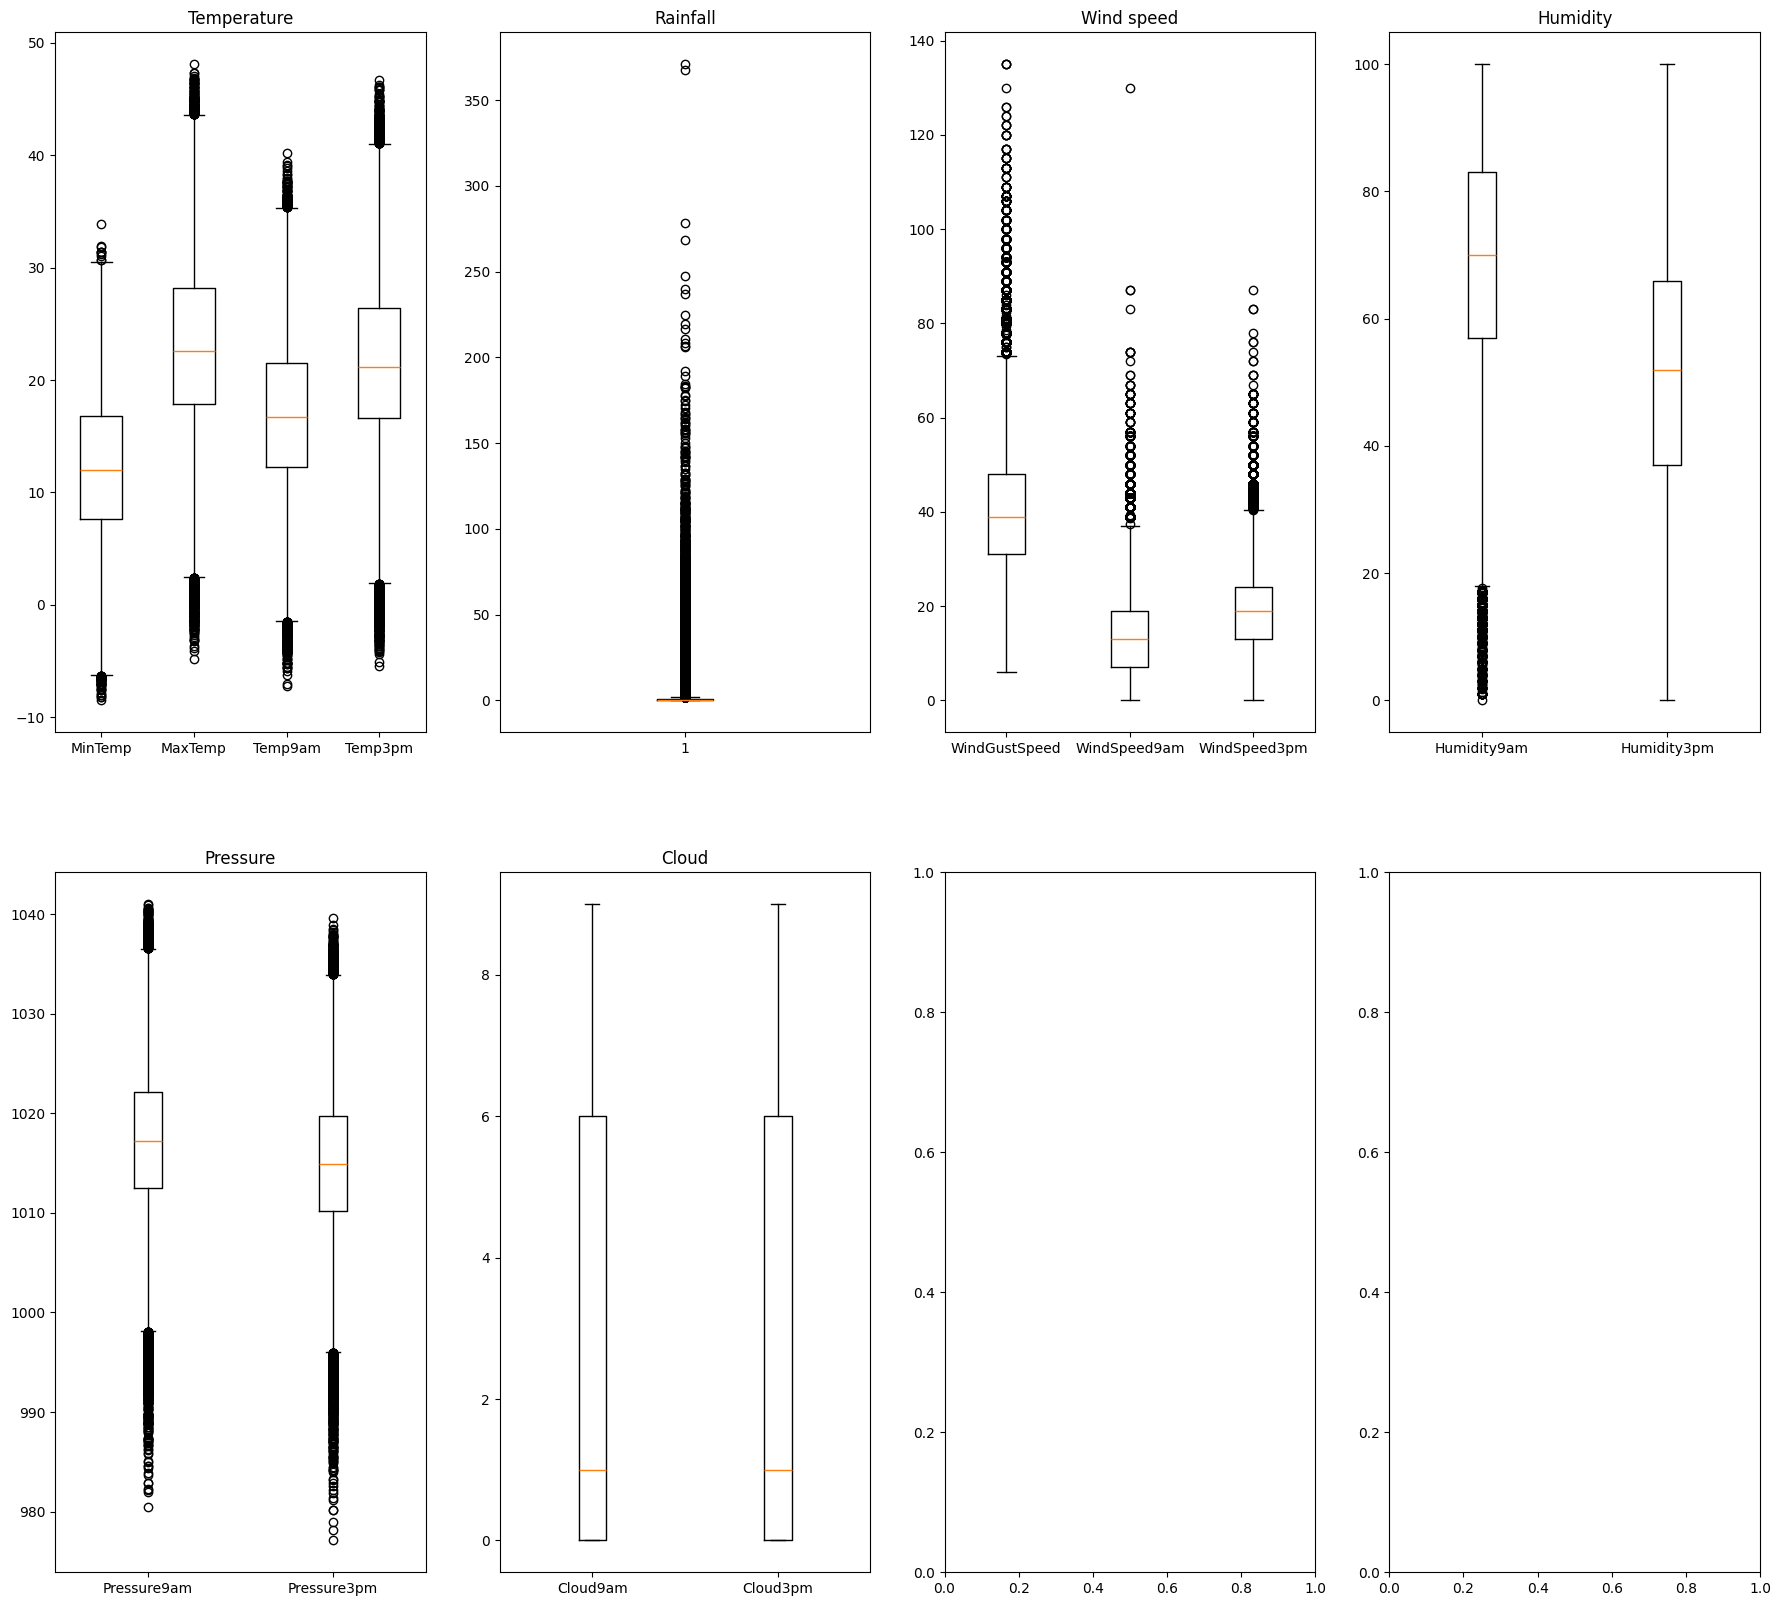

In [15]:
visualisation_data = data_filled.copy()
fig, axs = plt.subplots(2, 4, figsize=(22, 20), sharey=False)

# MinTemp MaxTemp Temp9am Temp3pm
axs[0][0].set_title('Temperature')
temperature_labels = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']
temperatures = visualisation_data[temperature_labels]
axs[0][0].boxplot(temperatures, tick_labels=temperature_labels)

# Rainfall Evaporation
axs[0][1].set_title('Rainfall')
rainfall = visualisation_data['Rainfall']
axs[0][1].boxplot(rainfall)

# WindGustSpeed WindSpeed9am WindSpeed3pm
axs[0][2].set_title('Wind speed')
wind_speed_labels = ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']
wind_speed = visualisation_data[wind_speed_labels]
axs[0][2].boxplot(wind_speed, tick_labels=wind_speed_labels)

# Humidity9am Humidity3pm
axs[0][3].set_title('Humidity')
humidity_labels = ['Humidity9am', 'Humidity3pm']
humidity = visualisation_data[humidity_labels]
axs[0][3].boxplot(humidity, tick_labels=humidity_labels)

# Pressure9am Pressure3pm
axs[1][0].set_title('Pressure')
pressure_labels = ['Pressure9am', 'Pressure3pm']
pressure = visualisation_data[pressure_labels]
axs[1][0].boxplot(pressure, tick_labels=pressure_labels)

# Cloud9am Cloud3pm
axs[1][1].set_title('Cloud')
cloud_labels = ['Cloud9am', 'Cloud3pm']
cloud = visualisation_data[cloud_labels]
axs[1][1].boxplot(cloud, tick_labels=cloud_labels)

## Year Location
#axs[1][2].set_title('Year range per location')
#axs[1][2].scatter(visualisation_data['Year'], visualisation_data['Location'])

## Month Day
#axs[1][3].set_title('Total day range per location')
#date = visualisation_data['Year'] * 353 + (visualisation_data['Month'] - 1) * 32 + visualisation_data['Day']
#axs[1][3].scatter(date, visualisation_data['Location'])

plt.show()

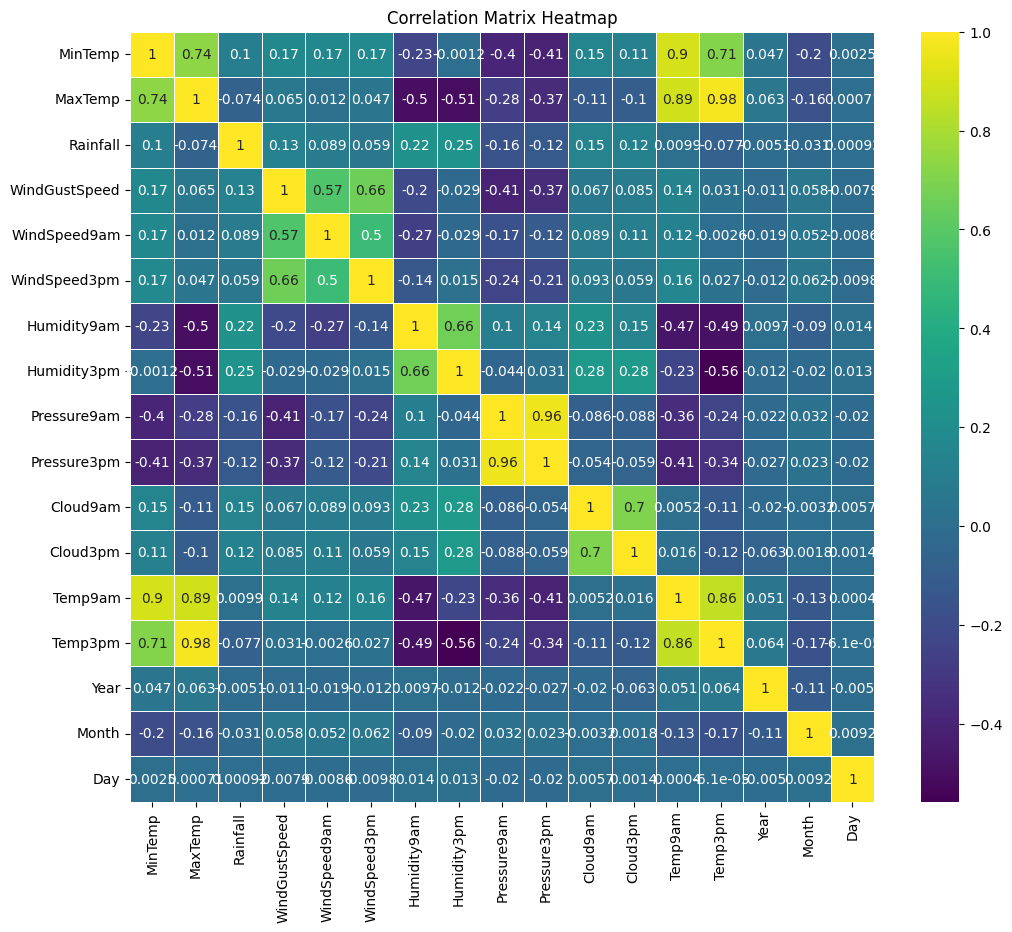

In [14]:
plt.figure(figsize=(12, 10))
corr_matrix = data_filled.corr()
sb.heatmap(corr_matrix, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

### Training

Create training, validation, and test data